# Analyse du dataset BUSINESS — modèle Random Forest

On reprend les étapes d'analyse communes, mais uniquement sur les vols Business, pour vérifier si le modèle apprend mieux les détails fins des prix (durée, escales, jours restants) une fois la classe retirée.

In [9]:
import numpy as np
import pandas as pd
import sklearn
 
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# Prétraitement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
 
# Prétraitement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
 
# Modèles de Machine Learning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import joblib
from sklearn.tree import export_text
 
# Évaluation des modèles
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_squared_error,
    r2_score
)

In [10]:
data = pd.read_csv("Clean_Dataset.csv")

data = data[data['class_ticket'] != 'Economy']
data.drop(columns=['class_ticket'], inplace=True)

print(data.head(10))

column_nan_count = data.isnull().sum()
print("NaN count per column:")
print(column_nan_count)

        Unnamed: 0    airline  flight source_city departure_time stops  \
206666      206666  Air_India  AI-868       Delhi        Evening  zero   
206667      206667  Air_India  AI-624       Delhi        Evening  zero   
206668      206668  Air_India  AI-531       Delhi        Evening   one   
206669      206669  Air_India  AI-839       Delhi          Night   one   
206670      206670  Air_India  AI-544       Delhi        Evening   one   
206671      206671    Vistara  UK-985       Delhi        Evening  zero   
206672      206672  Air_India  AI-479       Delhi          Night   one   
206673      206673  Air_India  AI-473       Delhi        Evening   one   
206674      206674    Vistara  UK-871       Delhi          Night   one   
206675      206675    Vistara  UK-977       Delhi        Evening  zero   

       arrival_time destination_city  duration  days_left  price  
206666      Evening           Mumbai      2.00          1  25612  
206667        Night           Mumbai      2.25     

In [11]:
print(data.describe())

          Unnamed: 0      duration     days_left          price
count   93487.000000  93487.000000  93487.000000   93487.000000
mean   253409.000000     13.704274     25.741857   52540.081124
std     26987.516645      6.852555     13.626538   12969.314606
min    206666.000000      1.000000      1.000000   12000.000000
25%    230037.500000      8.830000     14.000000   45185.000000
50%    253409.000000     13.080000     26.000000   53164.000000
75%    276780.500000     17.830000     38.000000   60396.000000
max    300152.000000     47.750000     49.000000  123071.000000


In [12]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 93487 entries, 206666 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        93487 non-null  int64  
 1   airline           93487 non-null  object 
 2   flight            93487 non-null  object 
 3   source_city       93487 non-null  object 
 4   departure_time    93487 non-null  object 
 5   stops             93487 non-null  object 
 6   arrival_time      93487 non-null  object 
 7   destination_city  93487 non-null  object 
 8   duration          93487 non-null  float64
 9   days_left         93487 non-null  int64  
 10  price             93487 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 8.6+ MB
None


# Colonnes :
- `Unnamed: 0` : index technique, à supprimer
- `airline` : nom de la compagnie aérienne (catégorielle)
- `flight` : code de vol, à supprimer (trop spécifique, inutile pour la prédiction)
- `source_city` : ville de départ (catégorielle)
- `departure_time` : créneau de départ ("Early_Morning", "Morning", "Afternoon", "Evening", "Night")
- `stop` : nombre d'escales
- `arrival_time` : créneau d'arrivée ("Early_Morning", "Morning", "Afternoon", "Evening", "Night")
- `destination_city` : ville d'arrivée (catégorielle)
- `duration` : durée du vol en heures (numérique)
- `days_left` : nombre de jours avant le départ (numérique)
- `price` : prix du billet en roupies indiennes — **variable cible**

In [13]:
df = data.drop(columns=['Unnamed: 0'], inplace=False)
df = df.drop(columns=['flight'], inplace=False)
# df = df.drop(columns=['airline'], inplace=False)

## Duplicates et valeurs manquantes

In [14]:
duplicate_count = df.duplicated().sum()
missing_values = df.isnull().sum()

df.drop_duplicates(inplace=True)
print(f"Nombre de doublons supprimés : {duplicate_count}")
print("Valeurs manquantes par colonne :")
print(missing_values)

Nombre de doublons supprimés : 314
Valeurs manquantes par colonne :
airline             0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
duration            0
days_left           0
price               0
dtype: int64


### Graphes pour visualiser les valeurs aberrantes et la distribution des données

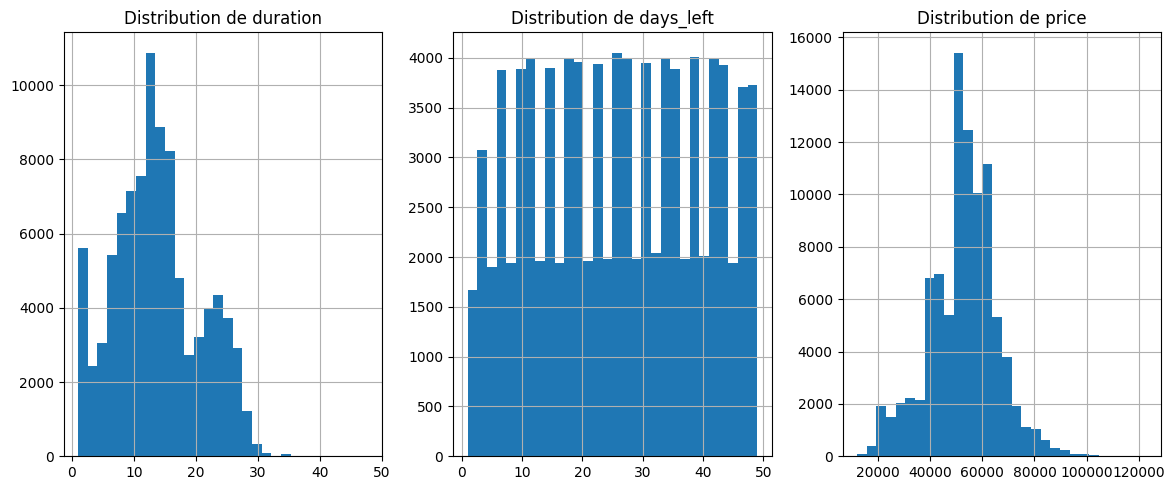

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
df.hist(column='duration', bins=30, ax=axes[0])
df.hist(column='days_left', bins=30, ax=axes[1])
df.hist(column='price', bins=30, ax=axes[2])
axes[0].set_title('Distribution de duration')
axes[1].set_title('Distribution de days_left')
axes[2].set_title('Distribution de price')
plt.tight_layout()
plt.show()

Comparé au dataset Economy, la distribution de `price` sur les vols Business est plus symétrique et moins étalée vers la droite.

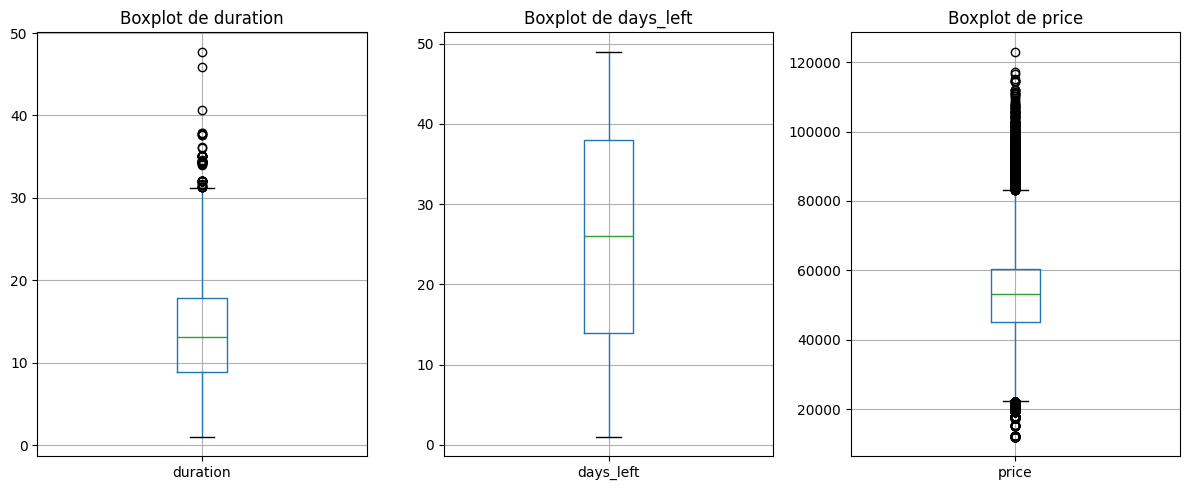

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
df.boxplot(column='duration', ax=axes[0])
df.boxplot(column='days_left', ax=axes[1])
df.boxplot(column='price', ax=axes[2])
axes[0].set_title('Boxplot de duration')
axes[1].set_title('Boxplot de days_left') 
axes[2].set_title('Boxplot de price') 
plt.tight_layout()
plt.show()

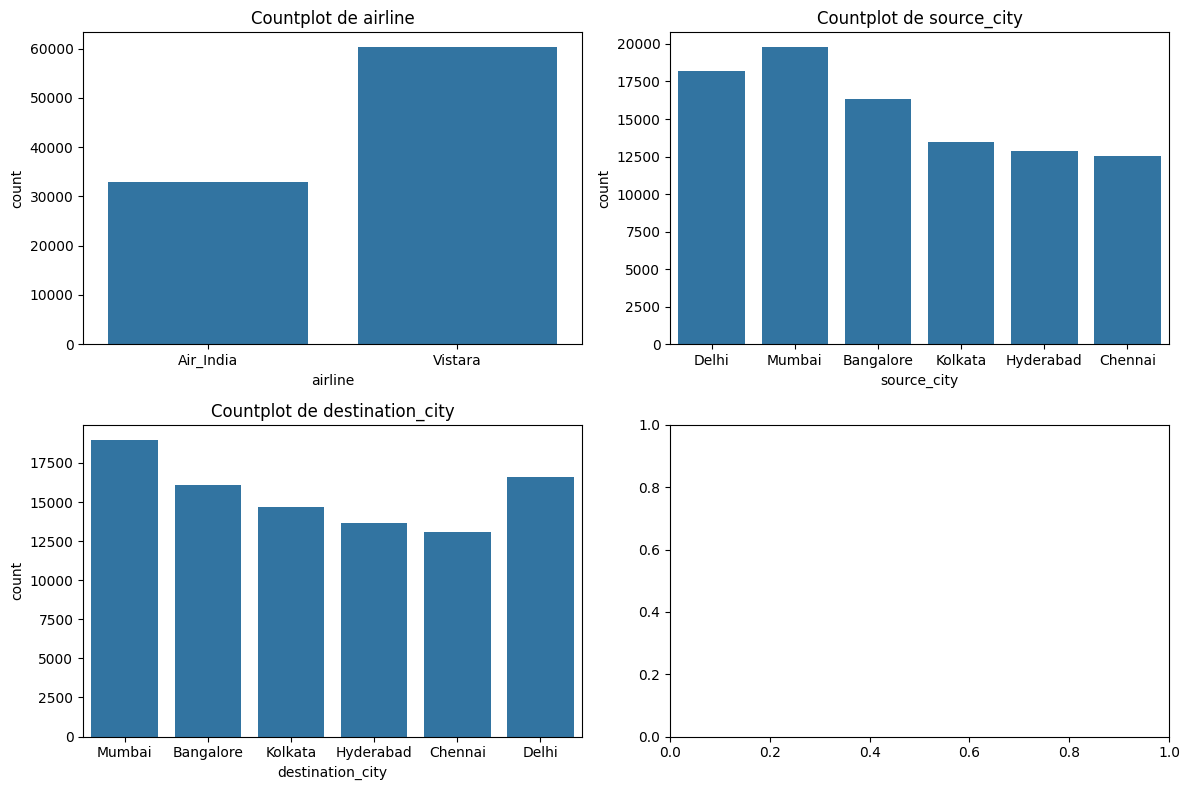

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.countplot(x=df['source_city'], ax=axes[0, 1])
axes[0, 1].set_title('Countplot de source_city')
sns.countplot(x=df['destination_city'], ax=axes[1, 0])
axes[1, 0].set_title('Countplot de destination_city')
sns.countplot(x=df['airline'], ax=axes[0, 0])
axes[0, 0].set_title('Countplot de airline')
plt.tight_layout()
plt.show()

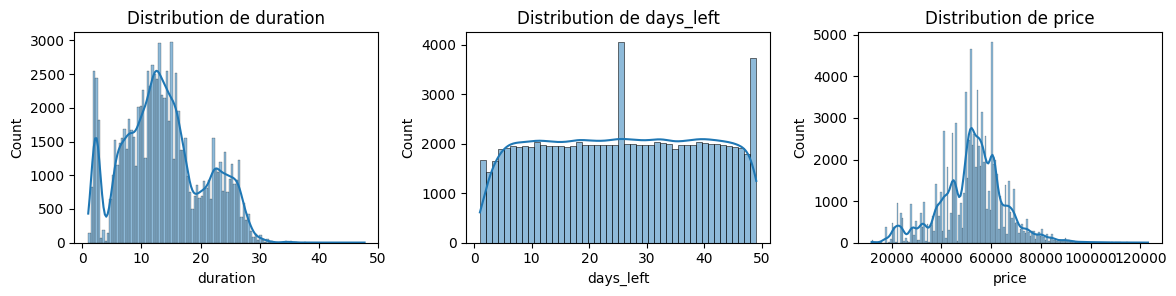

In [18]:
df_num = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
for i, column in enumerate(df_num.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_num[column], kde=True)
    plt.title(f'Distribution de {column}')
plt.tight_layout()
plt.show()

On voit mieux la répartition des variables numériques sur ce sous-ensemble, avec une distribution plus régulière que sur le dataset complet.

## Correlation entre les variables

Corrélation avec encodage OrdinalEncoder et OneHotEncoder pour inclure les variables catégorielles dans la matrice de corrélation.

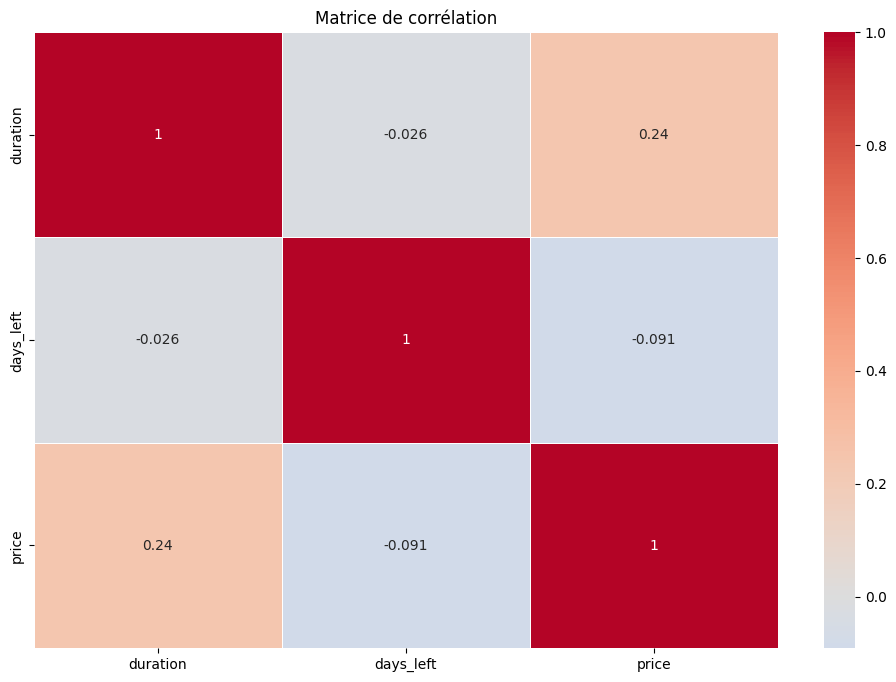

In [19]:
df_num = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

La corrélation entre `duration` et `price` est visible (~0.24), similaire au dataset Economy. Les résultats ne changent pas fortement par rapport au modèle de base.

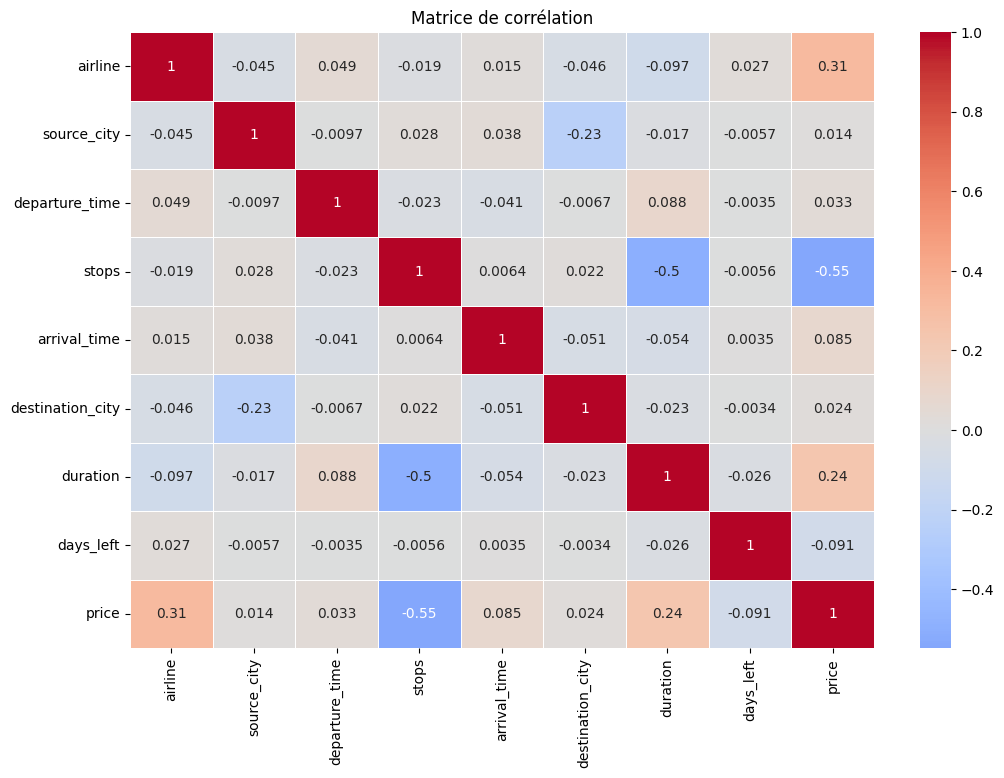

In [20]:
df2 = df.copy()
#encode les variables catégorielles using ordinal encoder
categorical_cols = df2.select_dtypes(include=['object', 'string']).columns
for col in categorical_cols:
    le = OrdinalEncoder()
    df2[col] = le.fit_transform(df2[col].values.reshape(-1, 1))

plt.figure(figsize=(12, 8))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

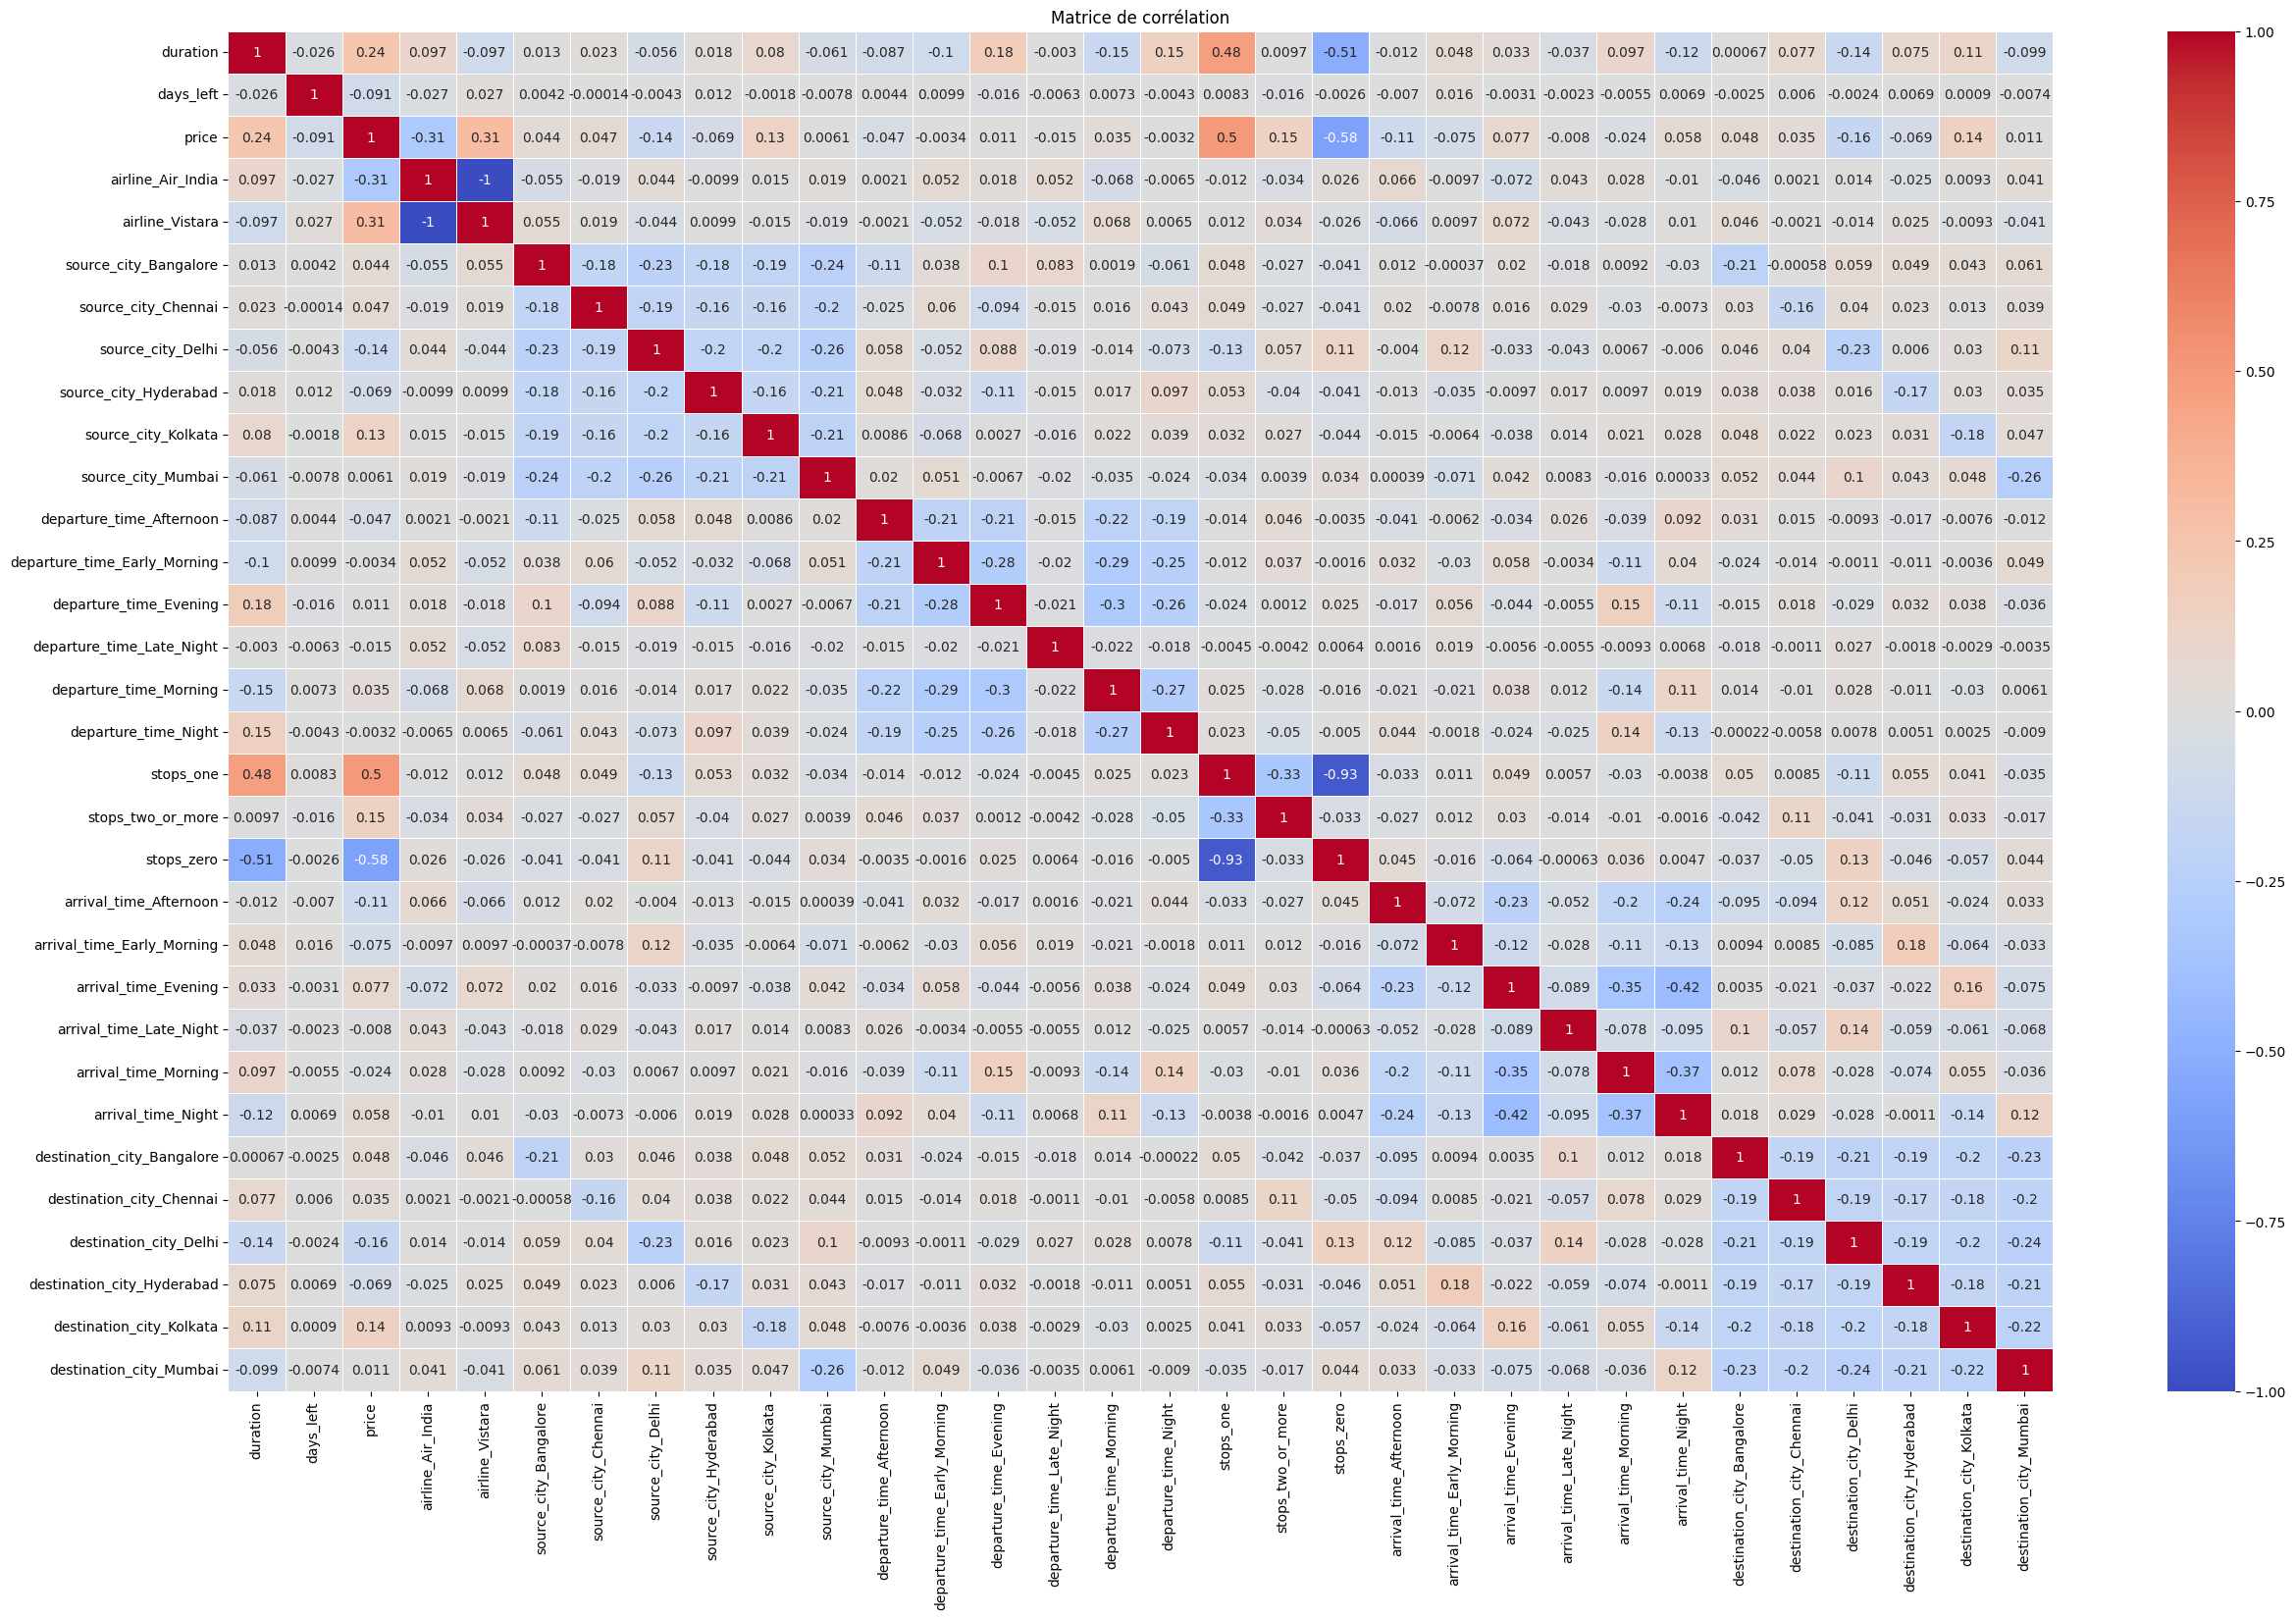

In [21]:
df3 = df.copy()
#encode les variables catégorielles using one hot encoder
categorical_cols = df3.select_dtypes(include=['object', 'string']).columns
df3 = pd.get_dummies(df3, columns=categorical_cols)

plt.figure(figsize=(30, 18))
sns.heatmap(df3.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

Avec le one-hot encoding, `stop` (~0.5) et Air Vistara (~0.31) montrent une corrélation plus forte avec `price`. La durée du vol (~0.24) est aussi prise en compte, contrairement au modèle complet.

In [22]:
print(df.columns)

Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'duration', 'days_left', 'price'],
      dtype='object')


In [23]:
X = df.drop(columns=['price'])
y = df['price']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Préprocessing — Pipeline sklearn

Même pipeline que l'analyse principale, appliqué uniquement sur le sous-ensemble Business :

- **Variables numériques** (`duration`, `days_left`) : imputation par médiane + `StandardScaler`.
- **Variables catégorielles** : imputation par valeur la plus fréquente + `OneHotEncoder`.

Le pipeline est entraîné sur `X_train` uniquement pour éviter toute fuite d'information.

In [25]:
num_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(include=['object', 'string']).columns

num_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
], verbose=True)

cat_process = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
], verbose=True)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_preprocess, num_cols),
        ("cat", cat_process, categorical_cols)
    ], remainder='passthrough', 
    verbose_feature_names_out=False
)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
], verbose=True)

In [26]:
print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  Index(['duration', 'days_left'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
         

In [27]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=  27.0s
RMSE: 4504.902876482935
R²: 0.8792159965037628


Résultat proche du modèle précédent. Le R² baisse légèrement par rapport au modèle complet, ce qui est attendu : on travaille sur environ 1/3 du dataset, avec moins de variété dans les données.

In [28]:
imputer = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['imputer']
imputer_categories = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['imputer']
print(dict(zip(num_cols, imputer.statistics_)))
print(dict(zip(categorical_cols, imputer_categories.statistics_)))

{'duration': np.float64(13.08), 'days_left': np.float64(26.0)}
{'airline': 'Vistara', 'source_city': 'Mumbai', 'departure_time': 'Morning', 'stops': 'one', 'arrival_time': 'Night', 'destination_city': 'Mumbai'}


In [29]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
rf_model = pipeline.named_steps['model']
importances = rf_model.feature_importances_

importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print(importances_df.head(10))

                     feature  importance
0                   duration    0.525875
1                  days_left    0.090277
2          airline_Air_India    0.043695
3            airline_Vistara    0.043593
6          source_city_Delhi    0.035901
27    destination_city_Delhi    0.031801
9         source_city_Mumbai    0.020338
30   destination_city_Mumbai    0.017092
29  destination_city_Kolkata    0.015894
8        source_city_Kolkata    0.015367


Sur le dataset Business, `duration` devient la variable dominante (~52%), suivie de `days_left` (~9%). C'est l'inverse du dataset Economy, ce qui montre que les prix Business sont davantage liés à la durée du vol qu'à l'anticipation de l'achat.

In [30]:
joblib.dump(pipeline, 'random_forest_flight_price_business.pkl')

['random_forest_flight_price_business.pkl']

In [31]:
loaded_model = joblib.load('random_forest_flight_price_business.pkl')
y_pred_loaded = loaded_model.predict(X_test)

print(f"R² Score (loaded model): {r2_score(y_test, y_pred_loaded)}")

R² Score (loaded model): 0.8792159965037628


In [32]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
tree = pipeline.named_steps['model'].estimators_[0]

print(export_text(tree, feature_names=list(feature_names), max_depth=4))

|--- duration <= -1.35
|   |--- duration <= -1.71
|   |   |--- duration <= -1.76
|   |   |   |--- duration <= -1.81
|   |   |   |   |--- source_city_Mumbai <= 0.50
|   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- source_city_Mumbai >  0.50
|   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- duration >  -1.81
|   |   |   |   |--- arrival_time_Morning <= 0.50
|   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |--- arrival_time_Morning >  0.50
|   |   |   |   |   |--- truncated branch of depth 7
|   |   |--- duration >  -1.76
|   |   |   |--- duration <= -1.72
|   |   |   |   |--- days_left <= -1.63
|   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |--- days_left >  -1.63
|   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |--- duration >  -1.72
|   |   |   |   |--- arrival_time_Night <= 0.50
|   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |--- arrival_time_Night >  0.50
|   

## Conclusion

Sur le dataset Business, le modèle prend davantage en compte `duration` et `stop`, des variables qui étaient masquées par `class_ticket` dans le modèle complet.

Les scores restent proches du modèle de base, probablement à cause de la réduction du volume de données (environ 1/3 du total). Pour améliorer la précision, on pourrait tester d'autres algorithmes ou enrichir le feature engineering.

## Analyse business et impact

**Impact métier :** sur le segment Business, `duration` est la variable dominante (~52%). Cela indique que le prix d'un billet Business dépend principalement de la durée du trajet, contrairement à Economy où c'est l'anticipation qui prime. Cette différence de comportement est utile pour adapter la stratégie tarifaire selon le segment de clientèle.

**Limites :**
- Le modèle est entraîné sur environ 1/3 du dataset original (vols Business uniquement), ce qui réduit la diversité des données.
- Certaines compagnies sont sur-représentées dans ce segment (ex. Vistara), ce qui peut biaiser les prédictions.

**Perspectives :** tester d'autres algorithmes (XGBoost, LightGBM) ou affiner le feature engineering (combinaisons route × durée) pourrait améliorer la précision sur ce sous-ensemble.